In [ ]:
# %pip install -q keras.src

In [ ]:
# %pip install -q tensorflow==2.12.0

In [ ]:
# %pip install -q keras==2.12.0

In [ ]:
# %pip install -q scikeras

In [ ]:
# %pip install -q yfinance

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# from tensorflow.keras.optimizers.legacy import Adam

In [2]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [5]:
# Define a transformer to preprocess the data
class DataPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_steps=60):
        self.n_steps = n_steps

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(X)
        training_data_len = int(np.ceil( len(X) * .83 ))
        train_data = scaled_data[0:int(training_data_len), :]

        test_data = scaled_data[training_data_len - 60: , :]
        # Create the data sets x_test and y_test
        x_test = []
        y_test = X[training_data_len:, :]
        x_test = np.array([test_data[i-60:i, 0] for i in range(60, len(test_data))])
        # Convert the data to a numpy array
        x_test = np.array(x_test)

        # Reshape the data
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

        X_transformed= []
        y_transformed =[]
        for i in range(self.n_steps, len(train_data)):
            # X_transformed.append(train_data[i-self.n_steps:i, 0])
            # y_transformed.append(train_data[i, 0])

            
            X_transformed = np.array([train_data[i-self.n_steps:i, 0] for i in range(self.n_steps, len(train_data))])
            y_transformed = np.array([train_data[i, 0] for i in range(self.n_steps, len(train_data))])
            
            X_transformed=np.array(X_transformed)
            y_transformed=np.array(y_transformed)
            X_transformed=np.reshape(X_transformed, (X_transformed.shape[0], X_transformed.shape[1], 1 ))
            # y_transformed=np.reshape( (y_transformed.shape[0], y_transformed.shape[1], 1 ))

        return X_transformed,y_transformed,x_test,y_test
        # return np.array(X_transformed), np.array(y_transformed)

In [6]:
# Define a custom LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define a transformer to convert predictions back to original scale
# class InverseScaler(BaseEstimator, TransformerMixin):
#     def __init__(self, scaler):
#         self.scaler = scaler

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         return self.scaler.inverse_transform(X)
    
keras_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=2, batch_size=1, verbose=2)

# Define the pipeline
preprocess_pipe = Pipeline([
    ('preprocessor', DataPreprocessor())])
pipe = Pipeline([
    ('model', keras_regressor)
    # assuming 'scaler' is defined somewhere
])

In [7]:
df1 = yf.download('TATASTEEL.NS', start='2000-01-01', end='2024-01-01')
# Create a new dataframe with only the 'Close column
data1 = df1.filter(['Close'])
# Convert the dataframe to a numpy array
dataset1 = data1.values

[*********************100%%**********************]  1 of 1 completed


In [8]:
data1.shape

(5993, 1)

In [9]:
dataset1

array([[  8.55930519],
       [  8.46666622],
       [  8.78950024],
       ...,
       [137.19999695],
       [138.1499939 ],
       [139.6000061 ]])

In [10]:
(preprocess_pipe.fit(dataset1))

Pipeline(steps=[('preprocessor', DataPreprocessor())])

In [11]:
x_n,y_n,test,y_test=preprocess_pipe.transform(dataset1)

In [12]:
print(x_n.shape)
print(y_n.shape)
print(test.shape)
print(y_test.shape)

(4915, 60, 1)
(4915,)
(1018, 60, 1)
(1018, 1)


In [13]:
pipe.fit(x_n,y_n)

Epoch 1/2
4915/4915 - 117s - 24ms/step - loss: 0.0010
Epoch 2/2
4915/4915 - 112s - 23ms/step - loss: 8.4372e-04


Pipeline(steps=[('model',
                 KerasRegressor(batch_size=1, build_fn=<function create_lstm_model at 0x7a639c308550>, epochs=2, verbose=2))])

In [14]:
predictions=pipe.predict(test)
predictions.shape


1018/1018 - 9s - 9ms/step


(1018,)

In [15]:
predictions=predictions.reshape(-1, 1)

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset1)

scaled_data

array([[0.03033118],
       [0.02974378],
       [0.03179078],
       ...,
       [0.84600573],
       [0.8520294 ],
       [0.86122352]])

In [17]:
predictions = scaler.inverse_transform(predictions)

In [18]:
predictions

array([[ 38.216385],
       [ 39.190582],
       [ 39.88352 ],
       ...,
       [128.85245 ],
       [130.15092 ],
       [131.04515 ]], dtype=float32)

In [19]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4.140829739538048

In [20]:
training_data_len=int(np.ceil( len(dataset1) * .83 ))
training_data_len

4975

In [21]:

# train = data1[:int(training_data_len)]
# valid = data1[int(trainig_data_len):]

# valid['Predictions'] = predictions

In [22]:
# train = data1[:4196]
# valid = data1[4196:]

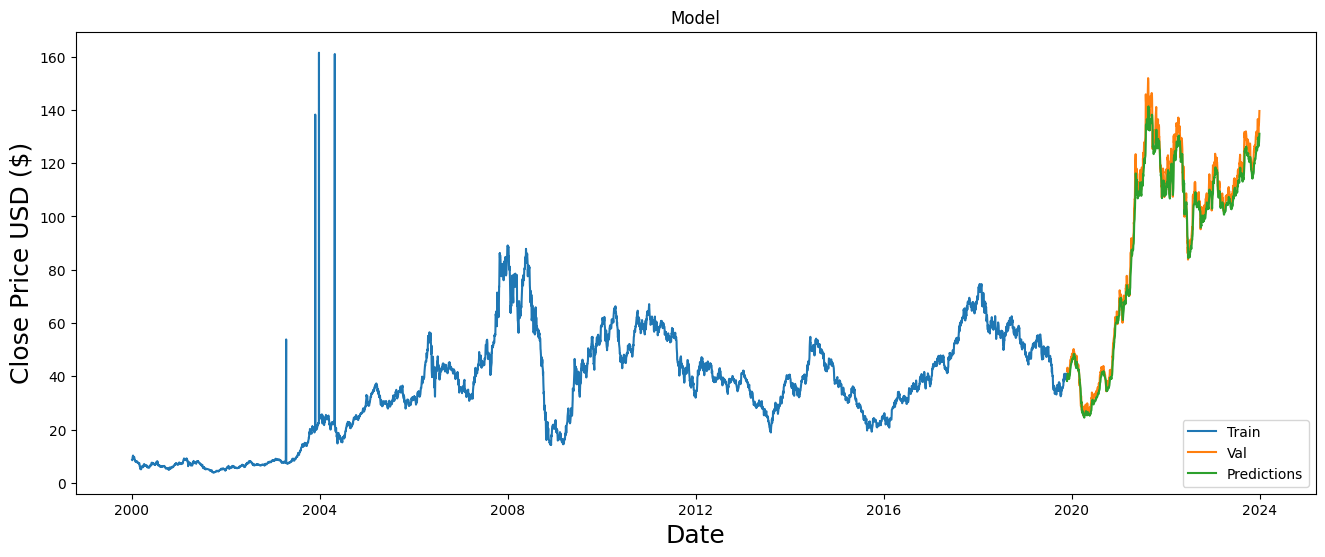

In [23]:
trainig_data_len=int(np.ceil( len(dataset1) * .83 ))
train = data1[:trainig_data_len]
valid = data1[trainig_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [24]:
# Define the list of stock symbols
stock_symbols = ['HDFCBANK.NS', 'TCS.NS', 'ICICIBANK.NS', 'INFY.NS', 'ADANIPOWER.NS',
                 'BAJFINANCE.NS', 'MARUTI.NS', 'HINDUNILVR.NS', 'ASIANPAINT.NS',
                 'DRREDDY.NS', 'LTIM.NS', 'EICHERMOT.NS', 'CHOLAFIN.NS',
                 'IDFCFIRSTB.NS', 'ASHOKLEY.NS', 'GESHIP.NS', 'SBICARD.NS',
                 'BRITANNIA.NS', 'IIFL.NS']

# Download historical data for each stock
stock_data = {}
for symbol in stock_symbols:
    data = yf.download(symbol, start='2000-01-01', end='2024-01-01')
    stock_data[symbol] = data

# Extract close prices for each stock
close_prices = {}
for symbol, data in stock_data.items():
    close_prices[symbol] = data['Close']

# Create DataFrames for each stock
stock_dfs = {}
for symbol, prices in close_prices.items():
    stock_dfs[symbol] = pd.DataFrame({'Close': prices})

# Convert close prices of each stock DataFrame into NumPy arrays
stock_arrays = {}
for symbol, df in stock_dfs.items():
    stock_arrays[symbol] = df['Close'].values
    stock_arrays[symbol]=stock_arrays[symbol].reshape(-1,1)

# Now you have the close price arrays for each stock in the stock_arrays dictionary


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [25]:
stock_arrays['TCS.NS']

array([[  39.70000076],
       [  39.16249847],
       [  36.46250153],
       ...,
       [3811.19995117],
       [3799.89990234],
       [3793.39990234]])

In [26]:
stock_data_dict = {}

for stock in stock_arrays.keys():
    stock_arrays[stock]=stock_arrays[stock].reshape(-1,1)
    # Fit the preprocessor pipeline to the current stock's data
    preprocess_pipe.fit(stock_arrays[stock])

In [57]:
for stock in stock_arrays.keys():
    # Transform the data
    x_transformed, y_transformed, x_test, y_test = preprocess_pipe.transform(stock_arrays[stock])
    stock_data_dict[stock] = {
        'x_transformed': x_transformed,
        'y_transformed': y_transformed,
        'x_test': x_test,
        'y_test': y_test}

In [63]:
pickle.dump(stock_data_dict,open("stock_data_dict2.h5","wb"))

In [68]:
dict2=pickle.load(open("stock_data_dict2.h5","rb"))


In [69]:
model=pickle.load(open("pipe.h5","rb"))

In [71]:
# model.predict(dict2['TCS.NS']['x_test'])

In [28]:
type(stock_data_dict['IIFL.NS']['x_test'])

numpy.ndarray

In [29]:
for stock in stock_arrays.keys():
    x_transformed = stock_data_dict[stock]['x_transformed']
    y_transformed = stock_data_dict[stock]['y_transformed']
    print()
    print("Loss for", stock)
    print()
    pipe.fit(x_transformed,y_transformed)


Loss for HDFCBANK.NS

Epoch 1/2
4915/4915 - 117s - 24ms/step - loss: 4.2838e-04
Epoch 2/2
4915/4915 - 114s - 23ms/step - loss: 1.5205e-04

Loss for TCS.NS

Epoch 1/2
4349/4349 - 103s - 24ms/step - loss: 3.0468e-04
Epoch 2/2
4349/4349 - 100s - 23ms/step - loss: 1.4532e-04

Loss for ICICIBANK.NS

Epoch 1/2
4373/4373 - 102s - 23ms/step - loss: 2.3006e-04
Epoch 2/2
4373/4373 - 142s - 32ms/step - loss: 1.0299e-04

Loss for INFY.NS

Epoch 1/2
4915/4915 - 115s - 23ms/step - loss: 1.7062e-04
Epoch 2/2
4915/4915 - 114s - 23ms/step - loss: 6.5272e-05

Loss for ADANIPOWER.NS

Epoch 1/2
2881/2881 - 70s - 24ms/step - loss: 1.3220e-04
Epoch 2/2
2881/2881 - 67s - 23ms/step - loss: 5.1422e-05

Loss for BAJFINANCE.NS

Epoch 1/2
4373/4373 - 104s - 24ms/step - loss: 4.0503e-04
Epoch 2/2
4373/4373 - 100s - 23ms/step - loss: 1.5005e-04

Loss for MARUTI.NS

Epoch 1/2
4154/4154 - 98s - 24ms/step - loss: 8.5879e-04
Epoch 2/2
4154/4154 - 142s - 34ms/step - loss: 3.4613e-04

Loss for HINDUNILVR.NS

Epoch 1/2
4

In [30]:
stock_data_dict['IIFL.NS']['x_test']

array([[[0.0908624 ],
        [0.09349824],
        [0.09523036],
        ...,
        [0.09997487],
        [0.10246009],
        [0.10750583]],

       [[0.09349824],
        [0.09523036],
        [0.09507974],
        ...,
        [0.10246009],
        [0.10750583],
        [0.11270219]],

       [[0.09523036],
        [0.09507974],
        [0.09666125],
        ...,
        [0.10750583],
        [0.11270219],
        [0.1135306 ]],

       ...,

       [[0.8687354 ],
        [0.88191459],
        [0.88741213],
        ...,
        [0.88379733],
        [0.84983262],
        [0.8796553 ]],

       [[0.88191459],
        [0.88741213],
        [0.90962847],
        ...,
        [0.84983262],
        [0.8796553 ],
        [0.86918724]],

       [[0.88741213],
        [0.90962847],
        [0.90985443],
        ...,
        [0.8796553 ],
        [0.86918724],
        [0.88718626]]])

In [31]:
for stock in stock_arrays.keys():
    x_test = stock_data_dict[stock]['x_test']
#     y_transformed = stock_data_dict[stock]['y_transformed']
    predictions = pipe.predict(x_test)
    stock_data_dict[stock] = {
        'predictions': predictions
    }

1018/1018 - 9s - 9ms/step
902/902 - 8s - 9ms/step
907/907 - 8s - 9ms/step
1018/1018 - 9s - 9ms/step
602/602 - 5s - 9ms/step
907/907 - 8s - 9ms/step
862/862 - 7s - 9ms/step
1018/1018 - 9s - 9ms/step
907/907 - 8s - 9ms/step
1018/1018 - 9s - 9ms/step
312/312 - 3s - 9ms/step
1018/1018 - 9s - 9ms/step
907/907 - 8s - 8ms/step
341/341 - 3s - 9ms/step
908/908 - 8s - 8ms/step
908/908 - 8s - 9ms/step
159/159 - 1s - 9ms/step
1018/1018 - 9s - 9ms/step
781/781 - 7s - 9ms/step


In [41]:
predictions1 = stock_data_dict['IIFL.NS']['predictions']
predictions1.shape

(781, 1)

In [36]:
for stock in stock_arrays.keys():
    predictions = stock_data_dict[stock]['predictions']
    predictions=predictions.reshape(-1, 1)
    # Inverse transform predictions
    predictions = scaler.inverse_transform(predictions)
    stock_data_dict[stock] = {
        'predictions': predictions
    }

In [38]:
import pickle

In [39]:
pickle.dump(pipe,open("pipe.h5","wb"))

In [40]:
pickle.dump(stock_data_dict,open("stock_data_dict.h5","wb"))

In [45]:
load=pickle.load(open("stock_data_dict.h5","rb"))

In [56]:
stock_data_dict['TCS.NS']['y_test']

KeyError: 'y_test'

In [42]:
for stock in stock_arrays.keys():
    predictions = stock_data_dict[stock]['predictions']
    y_test = stock_data_dict[stock]['y_test']
    rmse = np.sqrt(mean_squared_error(predictions, y_test))
    stock_data_dict[stock] = {
        'rmse': rmse
    }

KeyError: 'y_test'

In [ ]:
for stock in stock_arrays.keys():
    trainig_data_len=int(np.ceil( len(dataset1) * .83 ))
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print(valid)

In [ ]:
stock_data_dict['ASHOKLEY.NS']['x_test']

In [ ]:
# Define an empty dictionary to store data for each stock
stock_data_dict = {}

for stock in stock_arrays.keys():
    stock_arrays[stock]=stock_arrays[stock].reshape(-1,1)
    # Fit the preprocessor pipeline to the current stock's data
    preprocess_pipe.fit(stock_arrays[stock])
    
    # Transform the data
    x_transformed, y_transformed, x_test, y_test = preprocess_pipe.transform(stock_arrays[stock])
    
    # Make predictions
    predictions = pipe.predict(x_test)
    
    predictions=predictions.reshape(-1, 1)
    
    # Inverse transform predictions
    predictions = scaler.inverse_transform(predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(predictions, y_test))
    
    # Store data in the dictionary
    stock_data_dict[stock] = {
        'x_transformed': x_transformed,
        'y_transformed': y_transformed,
        'x_test': x_test,
        'y_test': y_test,
        'predictions': predictions,
        'rmse': rmse
    }
